<a href="https://colab.research.google.com/github/FredyRosero/Alg2_faroseroc/blob/main/Final_Project/Final_Project_Gr9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto final

## Problema
Se necesita diseñar e implementar un algoritmo de optimización que minimice el costo, una ejecución para minimizar el costo de Distancia y otra para el costo  Tiempo.

## Marco teórico
En teoría de grafo, el **problema de camino mas corto** es el problema de encontrar el camino entre dos nodos en un grafo tal que la suma de los pesos de las aristas qe lo constituyen se mínima

### Algoritmos
Los algoritmos más importantes para resolver este problema son:

* **Algoritmo de Dijkstra**, resuelve el problema de los caminos más cortos desde un único vértice origen hasta todos los otros vértices del grafo.
* **Algoritmo de Bellman - Ford**, resuelve el problema de los caminos más cortos desde un origen si la ponderación de las aristas es negativa.
* **Algoritmo de Búsqueda A***, resuelve el problema de los caminos más cortos entre un par de vértices usando la heurística para intentar agilizar la búsqueda.
* **Algoritmo de Floyd - Warshall**, resuelve el problema de los caminos más cortos entre todos los vértices.
* **Algoritmo de Johnson**, resuelve el problema de los caminos más cortos entre todos los vértices y puede ser más rápido que el de Floyd-Warshall en grafos de baja densidad.
* **Algoritmo de Viterbi**, resuelve el problema del camino estocástico más corto con un peso probabilístico adicional en cada vértice.

Nuestro grupo de trabajo decidió trabajar con el algoritmo Dijkstra por tener mas metarial divulgatorio disponible.

## Dependencias
En el desarrollo de esta presentación utilizaremos las siguientes dependencias. Esto no implica que serán las dependencias finales utilizadas en nuestra solución pero por su puesto algunas pueden volver a presentarse.

In [45]:
import pandas as pd #Para tratamiento de datos
import networkx as nx #Para presentación y comparación de rendimiento
import matplotlib.pyplot as plt #Para renderizar grafos
import pprint #Para depurar datos
import math #Para operaciones matemáticas
import numpy #Para utlidades 
import time #Para cronometras tiempos de ejecución

## 1. **Datos**
### 1.1. Descarga
Descargamos los datos de [co.mejoresrutas.com](https://co.mejoresrutas.com/tabla-de-distancias-entre-ciudades/co/) que represetan la matrix de adjacencia de conexión entre ciudades donde el peso de la conexión representa la distancia y el tiempo de conducción


In [46]:
url = 'https://co.mejoresrutas.com/tabla-de-distancias-entre-ciudades/co.csv?measure=time&type=road'
dftime = pd.read_csv(url)
url = 'https://co.mejoresrutas.com/tabla-de-distancias-entre-ciudades/co.csv?measure=metric&type=road'
dfdistance = pd.read_csv(url)
# Las tres últimas filas son incesarias
dftime = dftime[:-3]
dfdistance = dfdistance[:-3]

# Reemplaza los NaN por 0 o 0:00
dfdistance = dfdistance.fillna(0)
dftime = dftime.fillna("0:00")

# Mostramos el contenido
display(dftime)
display(dfdistance)

,Tiempo de conducción,Bogotá,Cali,Medellín,Barranquilla,Cartagena,Cúcuta,Bucaramanga,Pereira,Santa Marta,Ibagué,Pasto,Manizales,Neiva,Villavicencio,Armenia
0,Bogotá,0:00,6:27,5:45,12:04,13:34,7:18,5:05,4:42,11:30,2:39,11:02,4:18,3:49,1:28,4:08
1,Cali,6:27,0:00,5:43,14:23,13:54,12:25,10:10,2:39,15:07,3:54,7:06,3:20,6:25,7:41,2:22
2,Medellín,5:43,5:45,0:00,8:41,8:12,7:53,5:38,3:09,9:46,5:19,12:38,2:57,7:50,7:11,3:49
3,Barranquilla,12:02,14:15,8:32,0:00,1:53,8:51,7:55,11:40,1:15,11:53,21:09,11:28,14:09,13:30,12:20
4,Cartagena,13:43,13:53,8:10,1:50,0:00,10:31,9:36,11:17,3:04,13:27,20:46,11:05,15:50,15:11,11:57
5,Cúcuta,7:14,12:26,7:43,8:51,10:23,0:00,2:17,9:50,8:17,8:37,18:07,9:08,10:54,8:42,10:11
6,Bucaramanga,5:01,10:12,5:30,7:56,9:29,2:18,0:00,7:36,7:22,6:24,15:53,6:54,8:40,6:29,7:57
7,Pereira,4:44,2:40,3:09,11:50,11:20,9:52,7:37,0:00,12:33,2:11,9:33,0:47,4:43,5:58,0:42
8,Santa Marta,11:28,15:07,9:37,1:14,3:06,8:16,7:21,12:31,0:00,11:18,20:48,11:49,13:35,12:56,12:52
9,Ibagué,2:40,3:55,5:18,11:53,13:23,8:37,6:22,2:10,11:19,0:00,9:51,2:55,2:38,3:53,1:36


,Distancia (kilómetros),Bogotá,Cali,Medellín,Barranquilla,Cartagena,Cúcuta,Bucaramanga,Pereira,Santa Marta,Ibagué,Pasto,Manizales,Neiva,Villavicencio,Armenia
0,Bogotá,0.0,463.0,419.0,1009.0,1052.0,599.0,409.0,322.0,968.0,193.0,764.0,317.0,301.0,110.0,275.0
1,Cali,461.0,0.0,440.0,1144.0,1098.0,984.0,785.0,215.0,1231.0,274.0,393.0,268.0,382.0,558.0,187.0
2,Medellín,419.0,439.0,0.0,704.0,659.0,592.0,392.0,224.0,795.0,361.0,816.0,209.0,590.0,529.0,280.0
3,Barranquilla,1006.0,1139.0,702.0,0.0,122.0,669.0,642.0,924.0,102.0,991.0,1517.0,910.0,1178.0,1117.0,980.0
4,Cartagena,1078.0,1094.0,656.0,124.0,0.0,740.0,713.0,879.0,225.0,1015.0,1471.0,864.0,1249.0,1188.0,934.0
5,Cúcuta,596.0,982.0,590.0,669.0,741.0,0.0,200.0,767.0,628.0,705.0,1354.0,718.0,891.0,706.0,789.0
6,Bucaramanga,407.0,783.0,391.0,643.0,715.0,201.0,0.0,568.0,602.0,506.0,1155.0,519.0,692.0,517.0,590.0
7,Pereira,321.0,216.0,226.0,930.0,884.0,770.0,570.0,0.0,1017.0,134.0,593.0,54.0,336.0,418.0,53.0
8,Santa Marta,966.0,1229.0,793.0,101.0,223.0,629.0,602.0,1014.0,0.0,951.0,1600.0,964.0,1138.0,1077.0,1035.0
9,Ibagué,192.0,275.0,362.0,992.0,1035.0,705.0,505.0,133.0,951.0,0.0,669.0,190.0,206.0,288.0,86.0


### 1.2 Tratamiendo de datos
Podemos procesar la tabla de datos que caracteriza la matriz de adyacencia con los pesos, para obtener una lista de aristas de la forma `(ciudad origen, ciudad destino, peso)`

In [62]:
# Distancias
# dftime es un elemento tipo DataFrame
# Las ciudades es la primera columna ["Distancia (kilómetros)", "bogota", "B/manga",....] sin la primera fila ("Distancia (kilómetros)") : 
ciudades = list(dftime.columns)[1:]
# Inicializar lista
conexiones = []
# iterrows devuelve un iterable ...[1]:'Bucara 0 1 2 3 4 5 6'(serie)
for index,row in dfdistance.iterrows():
  # Row es un `Serie` de Panda
  # El primer elemento de la fila es el encabezado de la fila, la cual es la ciudad que esta conteniendo la fila
  ciudadOrigen = row[0]
  # Los siguientes elementos son `Serie`s (Ciudad,Peso)
  ciudadesDestino = row.iloc[1:]
  # Agregar a conexiones en la forma `(ciudadOrigen,ciudad,peso)`
  # [for de una sola línea]
  # for ciudad,peso in ciudadesDestino
  #   si peso !=0
  #     agrego (ciudadOrigen,ciudad,peso)
  [conexiones.append((ciudadOrigen,ciudad,peso)) for ciudad,peso in ciudadesDestino.items() if peso != 0]    
# PPrint funciona como print pero el formatea automaticamente las lista para mejor visualización
pprint.pprint(conexiones[:5])

[('Bogotá', 'Cali', 463.0),
 ('Bogotá', 'Medellín', 419.0),
 ('Bogotá', 'Barranquilla', 1009.0),
 ('Bogotá', 'Cartagena', 1052.0),
 ('Bogotá', 'Cúcuta', 599.0)]


In [63]:
# Tiempos

conexionesTiempo = []
for index,row in dftime.iterrows():
  # Row es un `Serie` de Panda
  # El primer elemento de la fila es el encabezado de la fila, la cual es la ciudad que esta conteniendo la fila
  ciudadOrigen = row[0]
  # Los siguientes elementos son `Serie`s (Ciudad,Peso)
  ciudadesDestino = row.iloc[1:]
  # Agregar a conexiones en la forma `(ciudadOrigen,ciudad,peso)`
  for ciudad,peso in ciudadesDestino.items():
    # Pasa el str tiempo de la forma 12:30 a 1230  ya que el peso de la conexión debe ser de tipo entero
    # TODO: 12:30 -> 12 + 30/60=0.5 -> 12,5 =? 1230/100 = 12,3
    hora,minu = peso.split(":")
    peso = int(hora) + int(minu)/60
    # peso = int(peso.replace(":","")) #
    if peso != 0: conexionesTiempo.append((ciudadOrigen,ciudad,peso))

pprint.pprint(conexionesTiempo[:5])

[('Bogotá', 'Cali', 6.45),
 ('Bogotá', 'Medellín', 5.75),
 ('Bogotá', 'Barranquilla', 12.066666666666666),
 ('Bogotá', 'Cartagena', 13.566666666666666),
 ('Bogotá', 'Cúcuta', 7.3)]


## 2. NetworkX
### 2.1. Grafo
Con la librería de NetworkX (ahora en adelante, NX) podemos crear instanciar objeto tipo Grafo direccionado DX con una serie de métodos que nos facilitarán el análisis preambular del problema

In [49]:
# Inicializar grafo
grafoDistancias = nx.DiGraph()
grafoTiempos = nx.DiGraph()
# Agrega nodos y conexiones
grafoDistancias.add_weighted_edges_from(conexiones)
grafoTiempos.add_weighted_edges_from(conexionesTiempo)
# Obtener pesos
# nx.get_edge_attributes() https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_edge_attributes.html
# Diccionario: Objeto[key]:value, key:(nodoA,nodoB), value:weight)
# Items() nos devuelve un lista iterable del diccionario: [(key1:value1),...]
# Zip empareja a modod cremallera dos listas
# PEro zip(*iterable) hace el proceso inverso: separa tubplas [key1,...],[value1,...]

conexionesLlave,pesos = zip(*nx.get_edge_attributes(grafoDistancias,'weight').items())

# Mapear el peso a un ancho
#   entrada(4mA)->salida(25%)
#   entrada(20mA)->salida(100%)
#   Hallar una ecuacion de recta y=mx+b que pase por (x1,y1)-(x2,y2)
#   Python hace eso con numpy.interp: esto  es una regresión lineal de solo dos puntos y evalua una ordenada
# Aplicar una funcion (numpy.interp) a una lista (pesos): map(funcion,lista)->objeto. FInalemtne se hace al objeto iterable
mapeadoAncho = []
mapeadoAncho = [numpy.interp(peso,[min(pesos),max(pesos)],[1,10]) for peso in pesos]

## 3. Gráfica
Que mejor para este análisis preambular del problema que dibujar el grafo para tener un panorama visual de a que nos estamos enfrentando

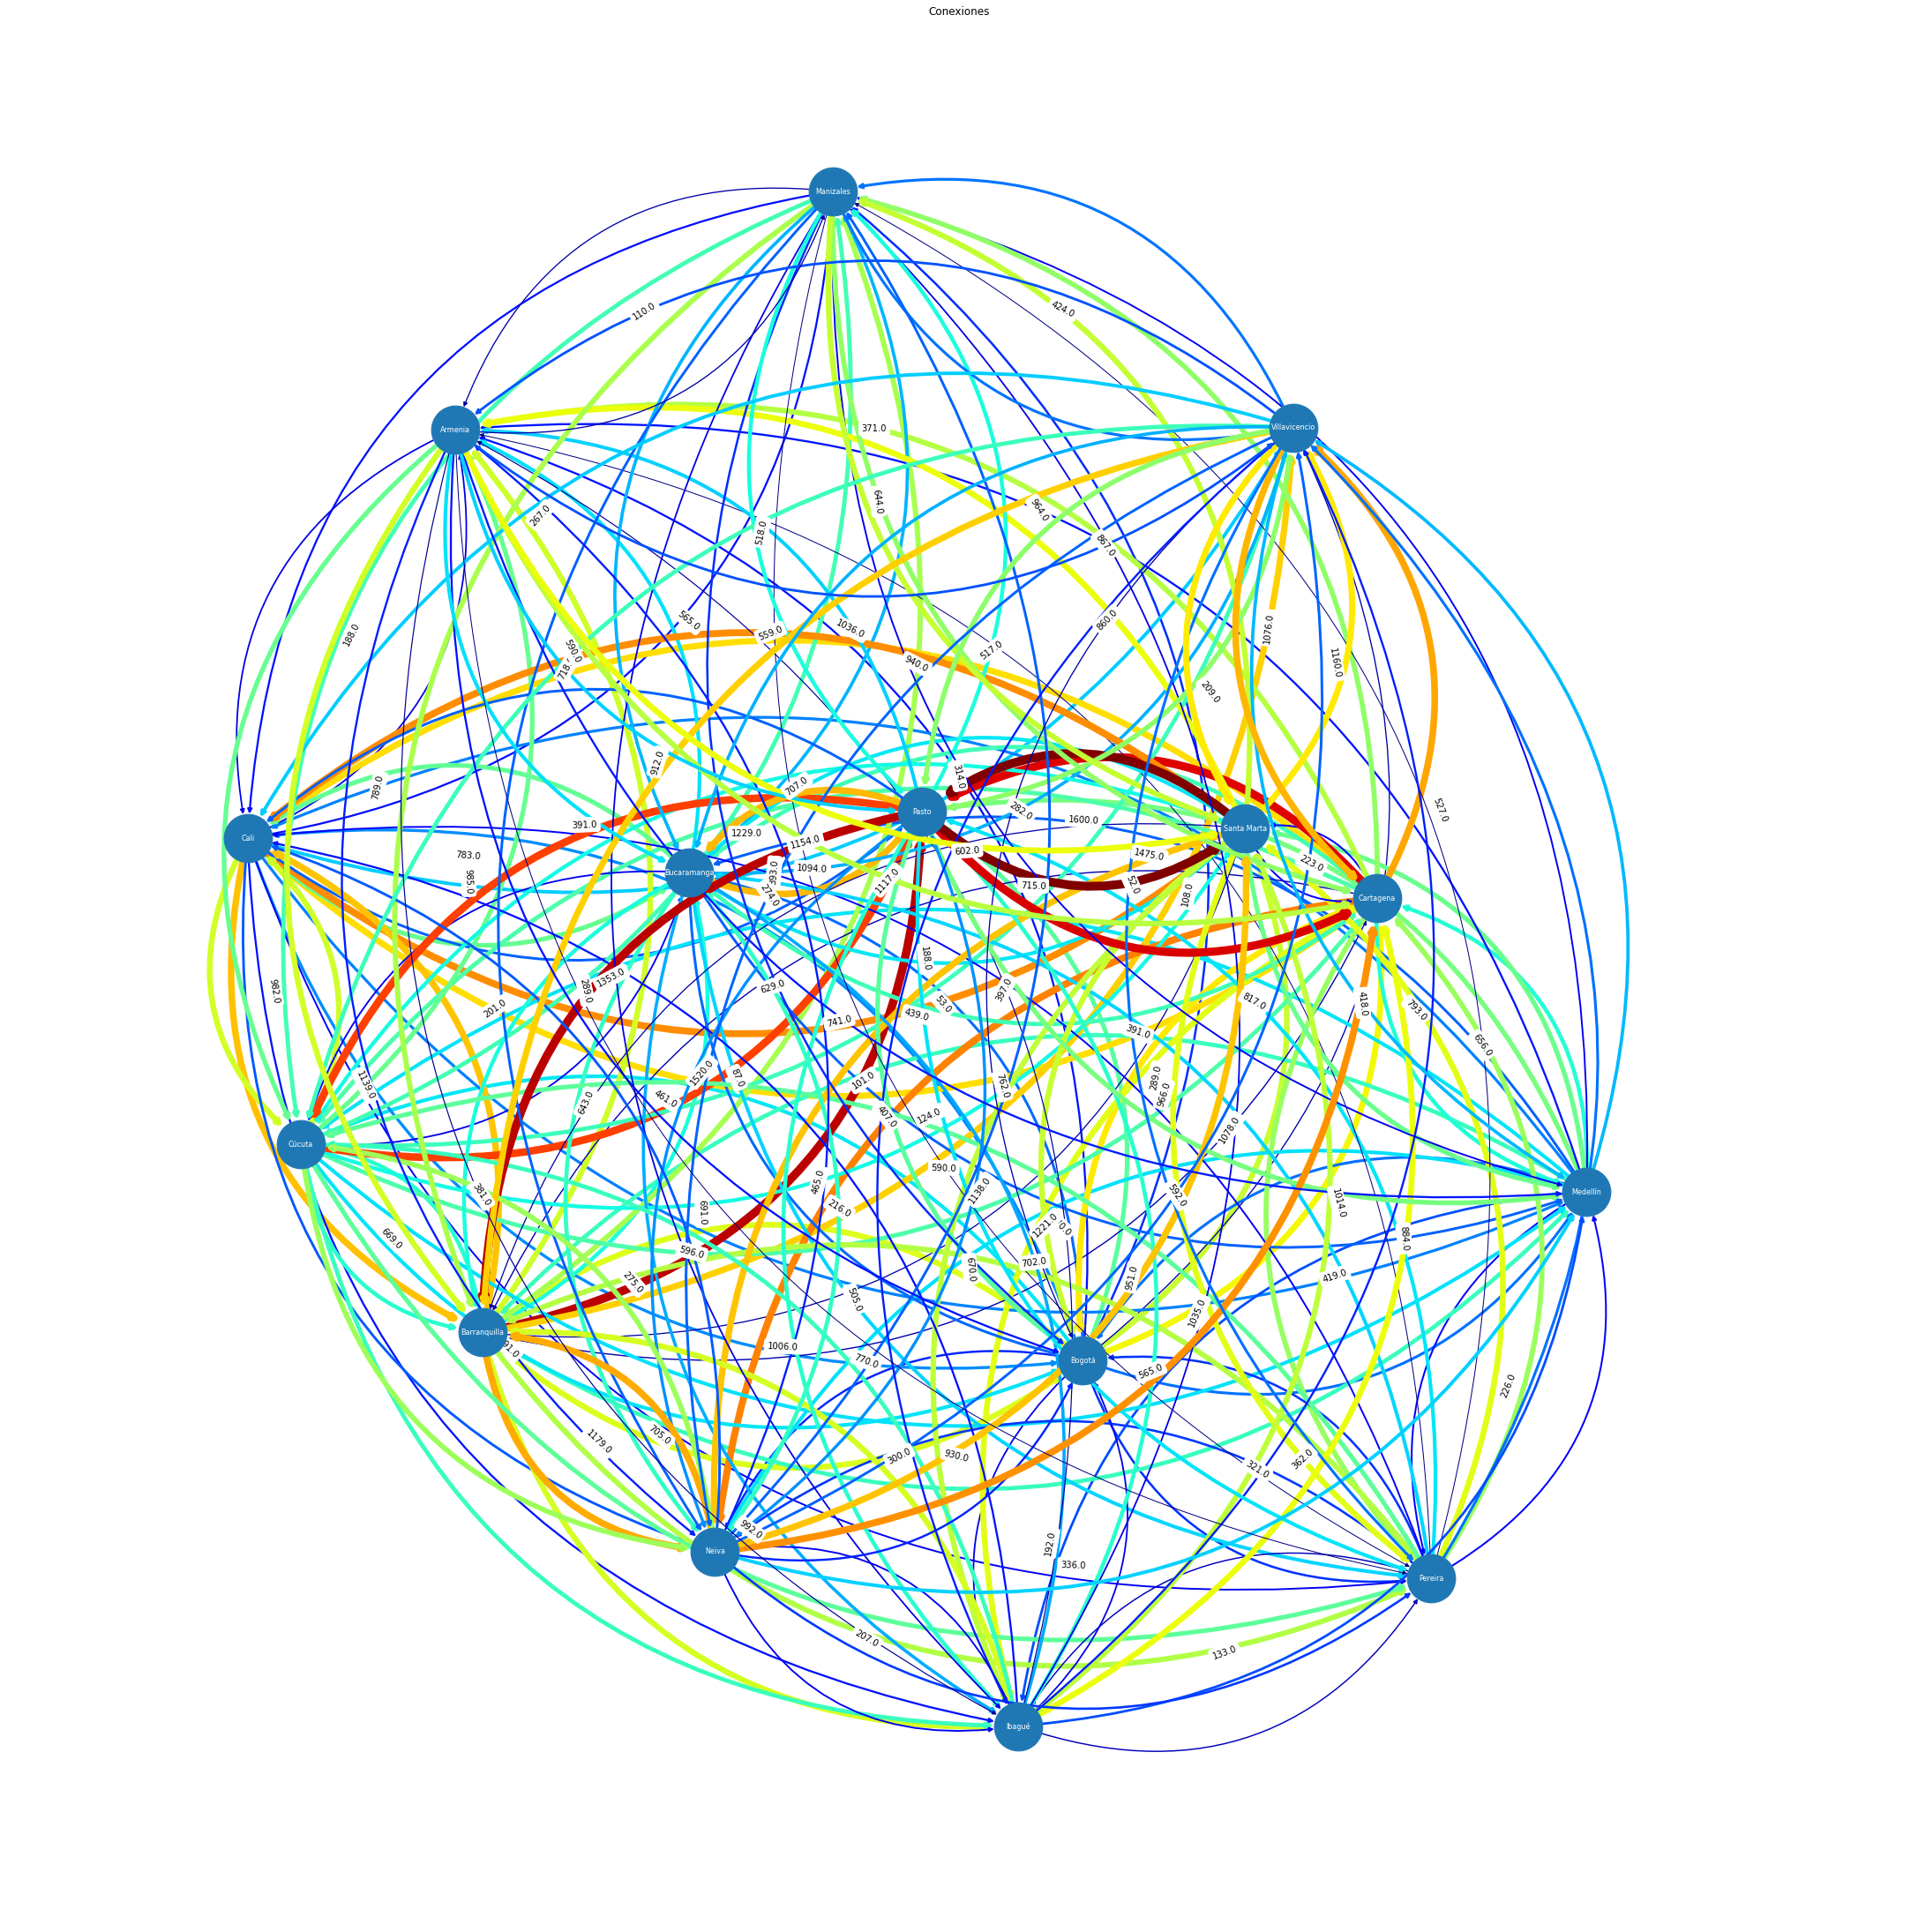

In [50]:


# Posiciones de nodos:
#   devuelve una lista de tuplas [(x1,y1),(x2,y2),...]
pos = nx.fruchterman_reingold_layout(grafoDistancias) 
# Definir tamaño para mejor resolución
plt.figure(figsize=(30,30)) 

# Dibujar nodos y conexiones
nx.draw(grafoDistancias, 
        pos, 
        with_labels     = True,  # Con nombre sobre el node
        node_size       = 3000, # Tamaño del nodo
        font_size       = 8, #Tamaño de la fuente
        font_color      = 'white', #Color de la fuente del nodo
        width           = mapeadoAncho, #ancho de la conexion mapeado
        edge_color      = pesos, #Color a mapear del nodo
        edge_cmap       = plt.cm.jet,  #escala (mapa de color) de colores rojo-azul (Calor)        
        connectionstyle = "arc3,rad=0.4" #curvatura de la conexion        
        )

# Dibujar etiquetas para las conexiones
nx.draw_networkx_edge_labels(grafoDistancias, 
                             pos, 
                             edge_labels=nx.get_edge_attributes(grafoDistancias,'weight'))
# Titulo
plt.title("Conexiones")

# Mostrar
plt.show()

## 4. Implementación propia de Dijkstra

In [51]:
from queue import PriorityQueue
def Dijkstra(grafo, inicio, destino):	
  # Lista: Guarda el camino realiado desde la ciudad de inicio hasta la ciudad de destino
  # Enlaza un nodo con su nodo anterior en el calculo del camino mas corto
  nodosPrevios = {}
	
	# nx.nodes(G)= [nodo1,nodo2,...,nodoN]
	# Objeto `pesos`:
	#		Es el peso (distancia o tiempo) de inicio a destino, 
	# 	contiene las distancias/tiempos o pesos relativos
	# 	desde el punto de vista del nodo inicial
	# Inicializar un diccionario (nodoX: peso[en infty]) excepto al nodo de origen
	# N=|ciudades|
	# O(N)
	
  pesosOptimos = {v: math.inf for v in list(nx.nodes(grafo))}
	# excepto al nodo de origen...
	# O(1)
  pesosOptimos[inicio] = 0

	# Cuando se cacula la distancia relativa a un nodo
	# Previene que se tengan en cuenta caminos mas largos
	# O(1)
  vecinosSinVisitar = PriorityQueue()

	# Desde el punto de vista del arbol,
	# Desde la raiz el primer vecino es el nodo de partida (inicio)  
	# O(1)
  vecinosSinVisitar.put((pesosOptimos[inicio], inicio))

	# Mientras hayan vecinos optimos que recorrer
	# Una arista nunca va estar mas de una vez en la cola `vecinosSinVisitar`
	# Si tenemos A,B,C,D,E,F estos estaran a lo mucho distribuidos en el tiempo en la cola
	# 1 {C}
	# 2 {A,B}
	# 3 {D,E}
	# 4 {F}
	
	# ó 
	# 1 {C}
	# 2 {A,B,D,E}
	# 4 {F}	

	# ò Tdoos vecinos inmediatos de C:
	# 1 {C}
	# 2 {A,B,D,E,F}

	# ò Todos en hilera:
	# 1 {C}
	# 2 {A}	
	# 3 {B}	
	# 4 {D}	
	# 5 {E}	
	# 6 {F}	
	# O(N)
  while vecinosSinVisitar.qsize() != 0: # -> O(N)*(O(E) + O(log N))
		# Extraer y eliminar: Como esta basado en un arbol binario tiene que reacomodar la mitad de los elementos
		# O(log N)
    _ , nodoActual = vecinosSinVisitar.get()
    
    # Itera sobre los nodos adjacentes del nodo Actual
		# dict(grafo.adjacency()) matrix de adjacencia
		# 'Santa Marta': {'Armenia': {'weight': 1252},
		# 							'Barranquilla': {'weight': 114},
		# 							'Bogotá': {'weight': 1128},
		# 							'Bucaramanga': {'weight': 721},
		# 							'Cali': {'weight': 1507},
		# 							'Cartagena': {'weight': 306},
		# 							'Cúcuta': {'weight': 816},
		# 							'Ibagué': {'weight': 1118},
		# 							'Manizales': {'weight': 1149},
		# 							'Medellín': {'weight': 937},
		# 							'Neiva': {'weight': 1335},
		# 							'Pasto': {'weight': 2048},
		# 							'Pereira': {'weight': 1231},
		# Recorrer cada uno de los nodos vecinos del nodo actal
		# 	la convierte en diccionario
		# 	y del diccionario extrae los de llave: {[nodoactual]=[nodoX],[nodoactual]=[nodoY],[nodoactual]=[nodoZ],...}
		# 	dict.get(nodoActual) es O(1) <- hash(nodoActual)
		# 	https://www.quora.com/Why-does-a-hash-table-have-O-1-search
		# 	Como el grafo es Fullconnected, |grafo.adjacency().get(nodoActual)| = |ciudades|
		# 	Por tanto el for es
		# O(E)
    for nodoAdyacente in dict(grafo.adjacency()).get(nodoActual):
			# grafo.get_edge_data nos da el peso de (nodoActual,nodoAdyacente). O los pesos (si son mas de un peso por arista)
			# path es la suma previamente calculada (camino anterior) con el peso de la actual arista
			# path va acumulando el peso para ciudada vecina a medida que se va bifurcando
			# Es el peso hasta el punto de partida (que se va acumulando) +MAS+ El peso desde el punto de partida al punto `nodoAdyacente`
			# O(1)
      caminoAcumulado = pesosOptimos[nodoActual] + grafo.get_edge_data(nodoActual,nodoAdyacente).get('weight')
      # Evalua si el nuevo camino es menor en peso al actual
	  	# ES una ruta mejor u optima?
      if caminoAcumulado < pesosOptimos[nodoAdyacente]:
        # Actualiza el nuevo peso junto con el nodo al cual se pasa
        pesosOptimos[nodoAdyacente] = caminoAcumulado

				# Diccionario: dict['ciudad'] = 'ciudad actual'
				# nodoActual, pop(0) de `cola`
				# Crea el arbol de conexión enlazando nodos, 
				# con una definicion de 'nodoOrigen' -> 'NodoPrevio -> ... -> Raiz(Inicio)
        nodosPrevios[nodoAdyacente] = nodoActual
				# dict
				# 	['Bogota']=B/manga
				# 	['Cali']=B/manga
				# 	['Pereria']=B/manga
				# 	....

        vecinosSinVisitar.put((caminoAcumulado, nodoAdyacente)) # ->O(1)
				#
			#Fin for: 
			# 1era iteracion va a agregar a cola todos los vecinos.
			# 2da iteracion

	# Se recorre el arbol de conexión representado en los enlaces de
	# nodosPrevios, para ir teniendo en cuenta los nodos
  nodo = destino
  camino = []
  peso = pesosOptimos[nodo]
  while nodo != inicio: # -> O(N-1): i.e.: Arbol como un Linked list lineal
    camino.append(nodo)
    nodo = nodosPrevios[nodo]
  camino.append(nodo) 
  camino.reverse()

  return camino, peso

##  5. Complejidad
```python
def Dijkstra(grafo, inicio, destino):	
  nodosPrevios = {} # O(1)
	
  pesosOptimos = {v: math.inf for v in list(nx.nodes(grafo))} # O(N)
  pesosOptimos[inicio] = 0 # O(1)

  vecinosSinVisitar = PriorityQueue() # O(1)
  vecinosSinVisitar.put((pesosOptimos[inicio], inicio)) # O(1)

  while vecinosSinVisitar.qsize() != 0: # O(E * log N)
    _ , nodoActual = vecinosSinVisitar.get() # O(log N)
    
    for nodoAdyacente in dict(grafo.adjacency()).get(nodoActual): # O(E)
			
      caminoAcumulado = pesosOptimos[nodoActual] + grafo.get_edge_data(nodoActual,nodoAdyacente).get ('weight') # O(1)

      if caminoAcumulado < pesosOptimos[nodoAdyacente]: # O(1)
        pesosOptimos[nodoAdyacente] = caminoAcumulado # O(1)
        nodosPrevios[nodoAdyacente] = nodoActual # O(1)
        vecinosSinVisitar.put((caminoAcumulado, nodoAdyacente)) # O(log N)

  nodo = destino # O(1)
  camino = [] # O(1)
  peso = pesosOptimos[nodo] # O(1)
  while nodo != inicio: # O(N-1): i.e.: Arbol como un Linked list lineal
    camino.append(nodo) # O(1) 
    nodo = nodosPrevios[nodo] # O(1)
  camino.append(nodo) # O(1)
  camino.reverse() # O(log N)

  return camino, peso
```
## Calculo del Big O es:
```   
O(1) + O(N) + 3*O(1) + O(N)*(O(log (N) + O(E)*(4*O(1) + O(log N)))) + 3*O(1) + O(N-1)*(2*O(1)) + O(1) + O(log N)

O(N) + O(N)*(O(log (N) + O(E)*(O(log N)))) + O(N-1) + O(log N)

O(N) + O(N)*(O(E + 1) * O(Log N)) + O(N-1) + O(log N)

O(N) + O(N)*(O(E) * O(Log N)) + O(N-1) + O(log N)

E = N porque puede ser fullconnected (worst-case)

O(N) + O(N^2) * O(Log N)) + O(N-1) + O(log N)

El total de vertices posible en un grafo dirigido de n nodos, es n(n-1) aprox -> n^2. Por tanto si E=N^2

O(N) + O(E) * O(Log N)) + O(N-1) + O(log N)

```

Por propiedades, el calculo de la complejidad para esta implementación del algoritmo de Dijkstra es:

```
O(E) * O(Log N))
```

## 6. Comparación de tiempo de Network
Para cotejar nuestros resultados es preciso saber la respuesta real del problema. Para esto nos apoyaremos de la función `Dijkstra` de NX. En nuestro caso particular nos piden hallar el camino mas corto entre Bucaramanga y Pasto

In [52]:
print(nx.dijkstra_path(grafoDistancias, 'Bucaramanga', 'Pasto'))
print(nx.dijkstra_path(grafoTiempos, 'Bucaramanga', 'Pasto'))
print()

# Caso de ejemplo donde la ruta cambia debido a los tiempos de viaje (es extraño pero se entiende viendo las tablas xd)
print(nx.dijkstra_path(grafoDistancias, 'Santa Marta', 'Villavicencio'))
print(nx.dijkstra_path(grafoTiempos, 'Santa Marta', 'Villavicencio'))

['Bucaramanga', 'Pasto']
['Bucaramanga', 'Pasto']

['Santa Marta', 'Bogotá', 'Villavicencio']
['Santa Marta', 'Villavicencio']


### Dijkstra Vs. A estrella
A estrella puede ser visto como una extensión del algoritmo de Dijkstra solo que A estrella tiene un mayor desepeño al usar eurísticas para focalizar su búsqueda.

In [61]:
# Medición del tiempo de ejecución para el algormitmo de Dijkstra y A* de NetworkX para una sola ciudad de origen y de destino

begin_time = time.time()
trayecto = nx.dijkstra_path(grafoDistancias, 'Bucaramanga', 'Pasto')
dijkstra_time = time.time() - begin_time

print(trayecto)
print("El tiempo para Dijkstra es de: {:.2f} milisegundos\n".format(dijkstra_time*1000))

begin_time = time.time()
trayecto = nx.astar_path(grafoDistancias,  'Bucaramanga', 'Pasto')
astar_time = time.time() - begin_time

print(trayecto)
print("El tiempo para A estrella es de: {:.2f} milisegundos\n".format(astar_time*1000))

['Bucaramanga', 'Pasto']
El tiempo para Dijkstra es de: 0.47 milisegundos

['Bucaramanga', 'Pasto']
El tiempo para A estrella es de: 0.72 milisegundos



## 7. Resultados de nuestra imlpementación
Tiempos de ejecución de nuestra implementación

In [60]:
#inicio = input("Ciudad de origen: ")
#destino = input("Ciudad de destino: ")

inicio = "Bucaramanga"
destino = "Pasto"

# Medición del tiempo para el algoritmo de Dijkstra usando la distancia como la conexión entre los nodos
begin_time = time.time()
camino, peso = Dijkstra(grafoDistancias, inicio, destino)
dijkstra_time = time.time() - begin_time

print(f"\nEl camino desde {inicio} hasta {destino} es: {camino}", sep="-")
print(f"La distancia del trayecto es: {peso} kilómetros \n")
print("El tiempo de ejecución fue de {:.2f} milisegundos\n".format(dijkstra_time*1000))
camino, peso = Dijkstra(grafoTiempos, inicio, destino)
pesoM,pesoH = math.modf(peso)
peso = "{:02d}:{:02d}".format(int(pesoH),int(pesoM*60))

print(f"El camino desde {inicio} hasta {destino} es: {camino}", sep="-")
print(f"El tiempo del trayecto es {peso} horas")


El camino desde Bucaramanga hasta Pasto es: ['Bucaramanga', 'Pasto']
La distancia del trayecto es: 1155.0 kilómetros 

El tiempo de ejecución fue de 0.86 milisegundos

El camino desde Bucaramanga hasta Pasto es: ['Bucaramanga', 'Pasto']
El tiempo del trayecto es 15:52 horas
